In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [2]:
IMAGE_WIDTH=28
IMAGE_HEIGHT=28
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
categories=[]
train_dir=os.listdir("train/")
for filename in train_dir:
    category=filename.split('.')[0]
    if category == 'bonghwang':
        categories.append('bonghwang')
    if category == 'dohwa':
        categories.append('dohwa')
    if category == 'gongjak':
        categories.append('gongjak')
    if category == 'horang':
        categories.append('horang')
    if category == 'so':
        categories.append('so')
    if category == 'yong':
        categories.append('yong')

In [4]:
df=pd.DataFrame({'filename':train_dir,'category':categories})
df

,filename,category
0,bonghwang.00001.jpg,bonghwang
1,bonghwang.00002.jpg,bonghwang
2,bonghwang.00003.jpg,bonghwang
3,bonghwang.00004.jpg,bonghwang
4,bonghwang.00005.jpg,bonghwang
...,...,...
33352,yong.05716.jpg,yong
33353,yong.05717.jpg,yong
33354,yong.05718.jpg,yong
33355,yong.05719.jpg,yong


In [5]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [6]:
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

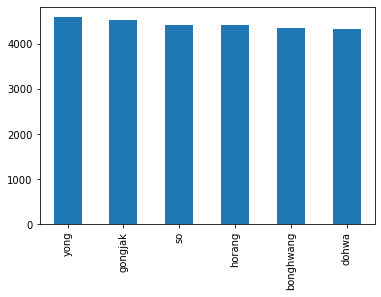

In [7]:
train_df['category'].value_counts().plot.bar()

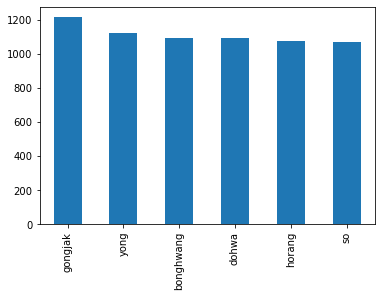

In [8]:
validate_df['category'].value_counts().plot.bar()

In [9]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [10]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

In [11]:
train_generator=train_datagen.flow_from_dataframe(train_df,
                                 'train/',
                                 x_col='filename',
                                 y_col='category',
                                  target_size=IMAGE_SIZE,
                                  class_mode='categorical',
                                  batch_size=batch_size
                                 )

Found 26685 validated image filenames belonging to 6 classes.


In [12]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              "train/",
                                                              x_col='filename',
                                                              y_col='category',
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='categorical',
                                                              batch_size=batch_size)

Found 6672 validated image filenames belonging to 6 classes.


In [13]:
from keras.models import Sequential
from keras.layers import *

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax')) # 2 because we have cat and dog classes
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [16]:
earlystop = EarlyStopping(patience=10),
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                           patience=2,
                                           verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [17]:
history = model.fit_generator(train_generator,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=total_validate//batch_size,
                              steps_per_epoch=total_train//batch_size,
                              callbacks=[earlystop,learning_rate_reduction])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
1779/1779 [==============================] - 18s 10ms/step - loss: 2.0251 - accuracy: 0.2309 - val_loss: 1.6862 - val_accuracy: 0.3029
Epoch 2/50
1779/1779 [==============================] - 18s 10ms/step - loss: 1.6735 - accuracy: 0.3004 - val_loss: 1.5058 - val_accuracy: 0.3731
Epoch 3/50
1779/1779 [==============================] - 18s 10ms/step - loss: 1.5924 - accuracy: 0.3441 - val_loss: 1.4705 - val_accuracy: 0.3985
Epoch 4/50
1779/1779 [==============================] - 18s 10ms/step - loss: 1.5378 - accuracy: 0.3762 - val_loss: 1.3640 - val_accuracy: 0.4517
Epoch 5/50
1779/1779 [==============================] - 18s 10ms/step - loss: 1.4937 - accuracy: 0.3926 - val_loss: 1.4216 - val_accuracy: 0.4492
Epoch 6/50
1779/1779 [==============================] - 18s 10ms/step - loss: 1.4470 - accuracy: 0.4201 - val_loss: 1.1984 - val_accuracy: 0.5314
Epoch 7/50
1779/1779 [==========================

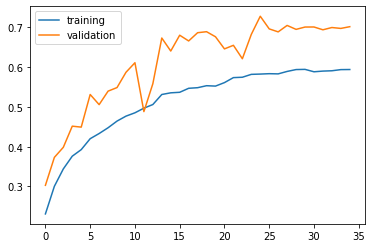

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [20]:
# test_dir = os.listdir("test/")
# test_df = pd.DataFrame({'filename': test_dir})
# nb_samples = test_df.shape[0]

In [21]:
# test_gen = ImageDataGenerator(rescale=1./255)

# test_generator = test_gen.flow_from_dataframe(test_df,
#                                               "test/",
#                                               x_col='filename',
#                                               y_col=None,
#                                               class_mode=None,
#                                               target_size=IMAGE_SIZE,
#                                               batch_size=batch_size,
#                                               shuffle=False)

Found 34 validated image filenames.


In [26]:
# predict = model.predict_generator(test_generator,steps=np.ceil(nb_samples/batch_size))

In [27]:
# test_df['category'] = np.argmax(predict, axis=-1)

In [28]:
# label_map = dict((v,k) for k,v in train_generator.class_indices.items())
# test_df['category'] = test_df['category'].replace(label_map)

In [29]:
# test_df